# 📊 Resume Dataset Analysis Notebook

This notebook contains interactive visualizations for the Resume Skill Matcher dataset.

## Visualizations:
1. **Category Distribution**
2. **Resume Length Analysis**
3. **Word Clouds**
4. **Skill Correlation Heatmap**

In [5]:
# ✅ Auto-Install Dependencies (Fix for ModuleNotFoundError)
import sys

print("Checking and installing dependencies...")
!{sys.executable} -m pip install wordcloud seaborn matplotlib pandas nltk
print("Dependencies installed! Now importing...")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from collections import Counter
from itertools import combinations
import os

# Setup
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Load Data
csv_path = os.path.join("..", "Resume", "Resume.csv")

try:
    df = pd.read_csv(csv_path)
    print(f"✅ Loaded {len(df)} records from {csv_path}")
    display(df.head())
except FileNotFoundError:
    print(f"❌ File not found at {csv_path}. Please check the path.")

Checking and installing dependencies...
Dependencies installed! Now importing...
✅ Loaded 2484 records from ..\Resume\Resume.csv


,ID,Resume_str,Resume_html,Category
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,"<div class=""fontsize fontface vmargins hmargin...",HR
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...","<div class=""fontsize fontface vmargins hmargin...",HR
2,33176873,HR DIRECTOR Summary Over 2...,"<div class=""fontsize fontface vmargins hmargin...",HR
3,27018550,HR SPECIALIST Summary Dedica...,"<div class=""fontsize fontface vmargins hmargin...",HR
4,17812897,HR MANAGER Skill Highlights ...,"<div class=""fontsize fontface vmargins hmargin...",HR


## 1. Category Distribution
Overview of how many resumes belong to each category.

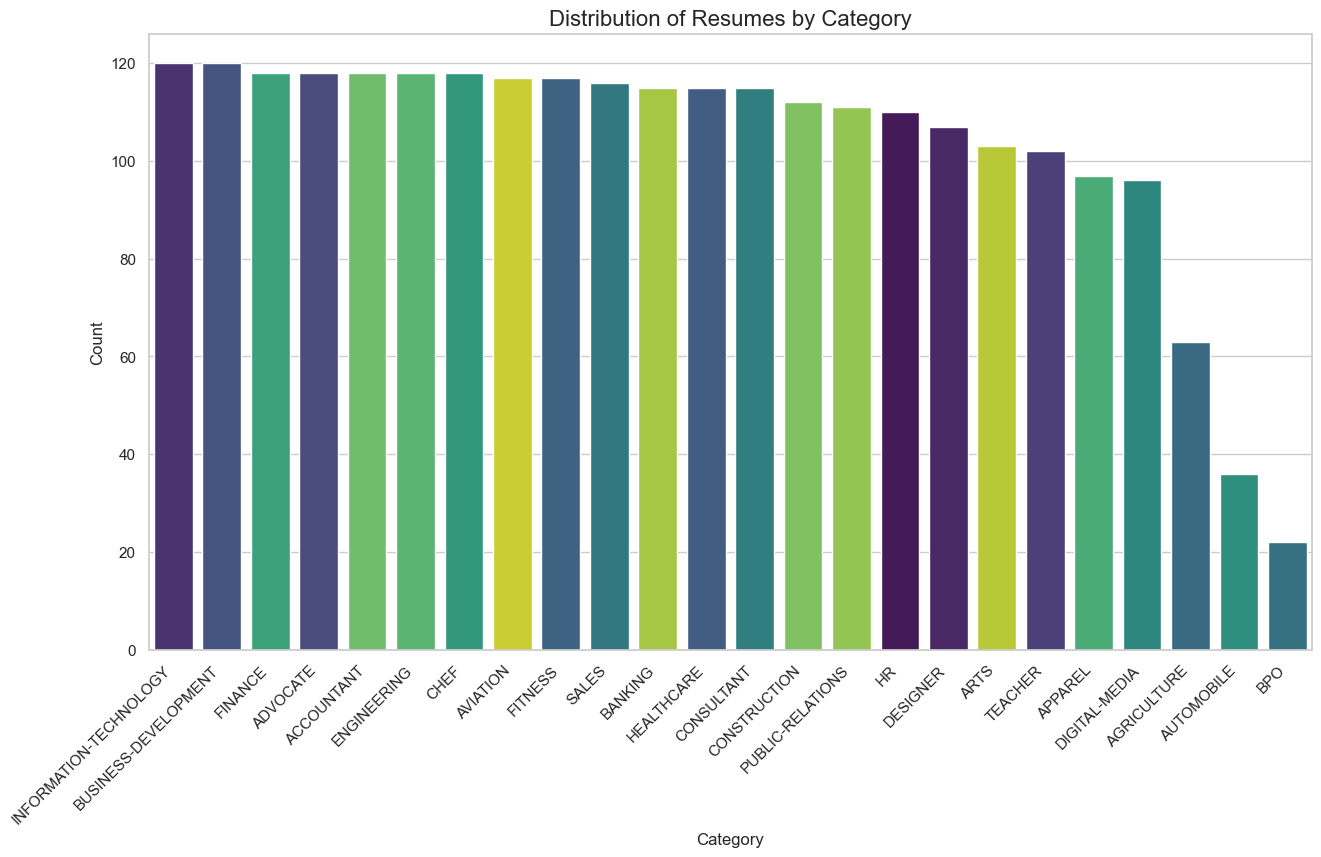

In [6]:
plt.figure(figsize=(15, 8))
ax = sns.countplot(
    data=df, 
    x="Category", 
    order=df['Category'].value_counts().index, 
    palette="viridis",
    hue="Category",
    legend=False
)
plt.xticks(rotation=45, ha='right')
plt.title("Distribution of Resumes by Category", fontsize=16)
plt.xlabel("Category")
plt.ylabel("Count")
plt.show()

## 2. Resume Length Analysis
Distribution of word counts across resumes.

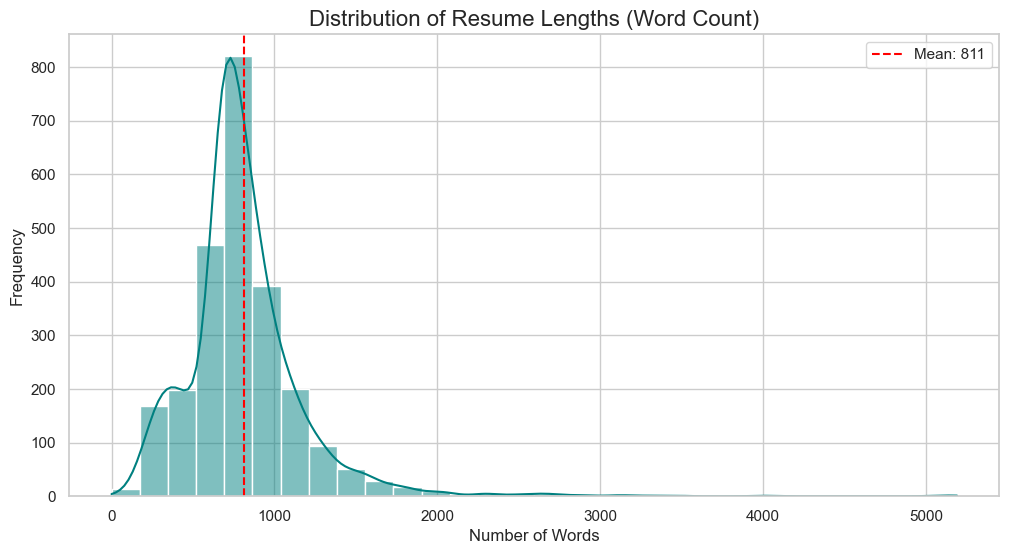

In [7]:
df['Word_Count'] = df['Resume_str'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(12, 6))
sns.histplot(df['Word_Count'], bins=30, kde=True, color='teal')
plt.title("Distribution of Resume Lengths (Word Count)", fontsize=16)
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.axvline(df['Word_Count'].mean(), color='red', linestyle='--', label=f"Mean: {int(df['Word_Count'].mean())}")
plt.legend()
plt.show()

### Length by Category

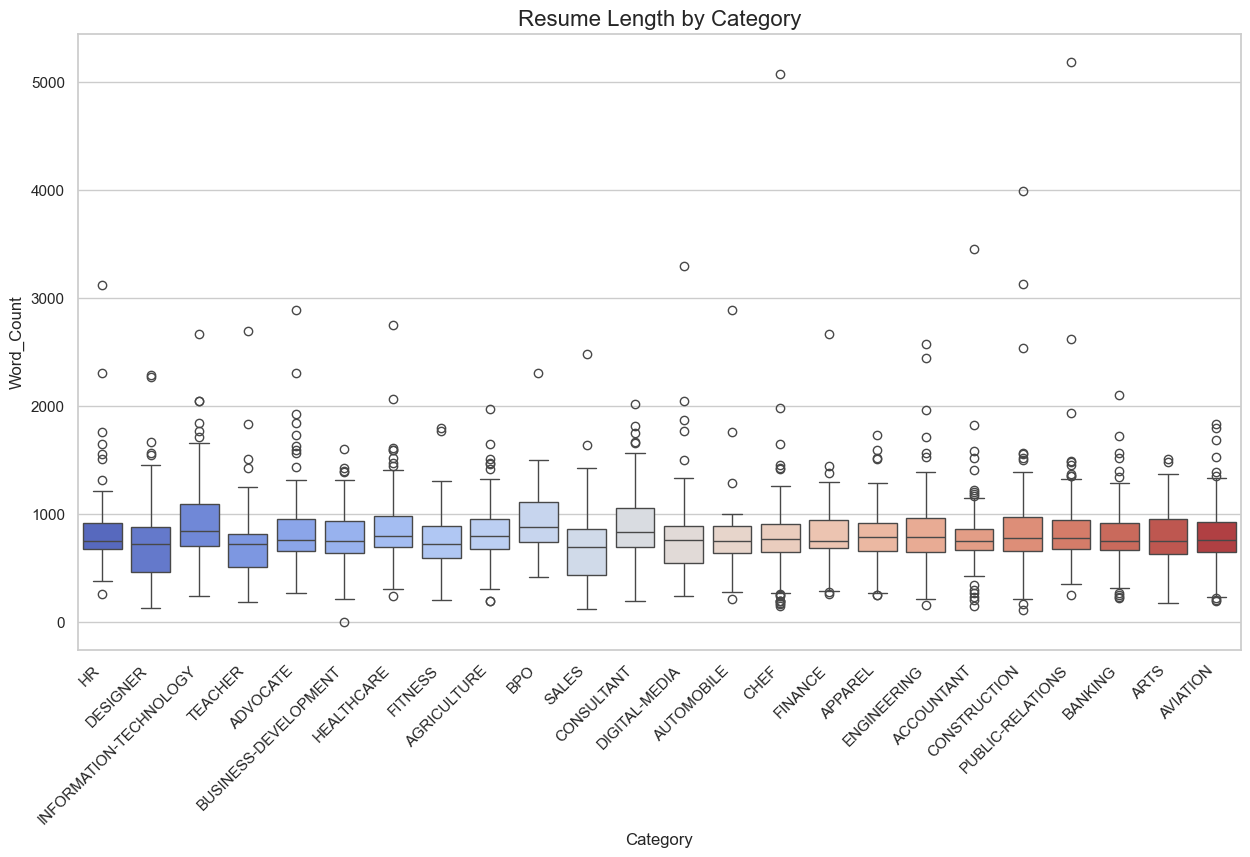

In [8]:
plt.figure(figsize=(15, 8))
sns.boxplot(data=df, x="Category", y="Word_Count", palette="coolwarm", hue="Category", legend=False)
plt.xticks(rotation=45, ha='right')
plt.title("Resume Length by Category", fontsize=16)
plt.show()

## 3. Word Clouds for Top Categories
Visualizing the most frequent terms in the largest categories.

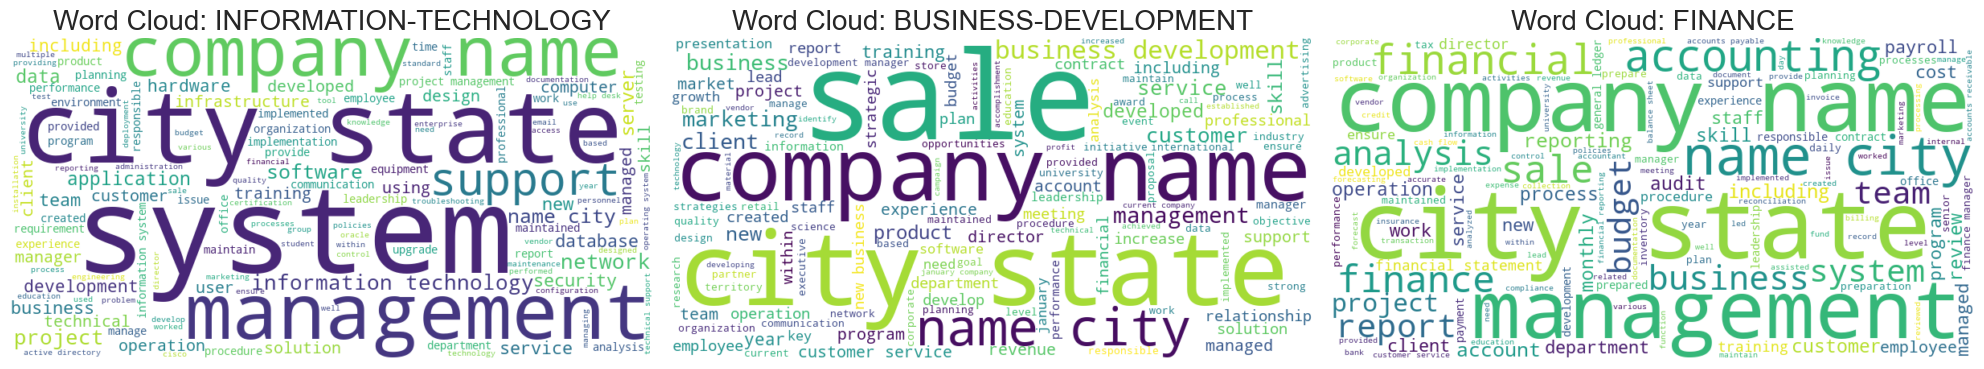

In [9]:
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def clean_text_simple(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z ]', '', text)
    return text

# Select Top 3 Categories
top_categories = df['Category'].value_counts().index[:3]

plt.figure(figsize=(20, 10))

for i, category in enumerate(top_categories):
    # Filter text for this category
    cat_text = " ".join(df[df['Category'] == category]['Resume_str'].apply(clean_text_simple))
    
    # Generate Cloud
    wc = WordCloud(
        width=800, 
        height=400, 
        background_color='white',
        stopwords=stop_words,
        min_font_size=10
    ).generate(cat_text)
    
    plt.subplot(1, 3, i+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud: {category}", fontsize=20)

plt.tight_layout()
plt.show()

## 4. Skill Co-occurrence Heatmap
How often do skills appear together? (Top 15 Skills)

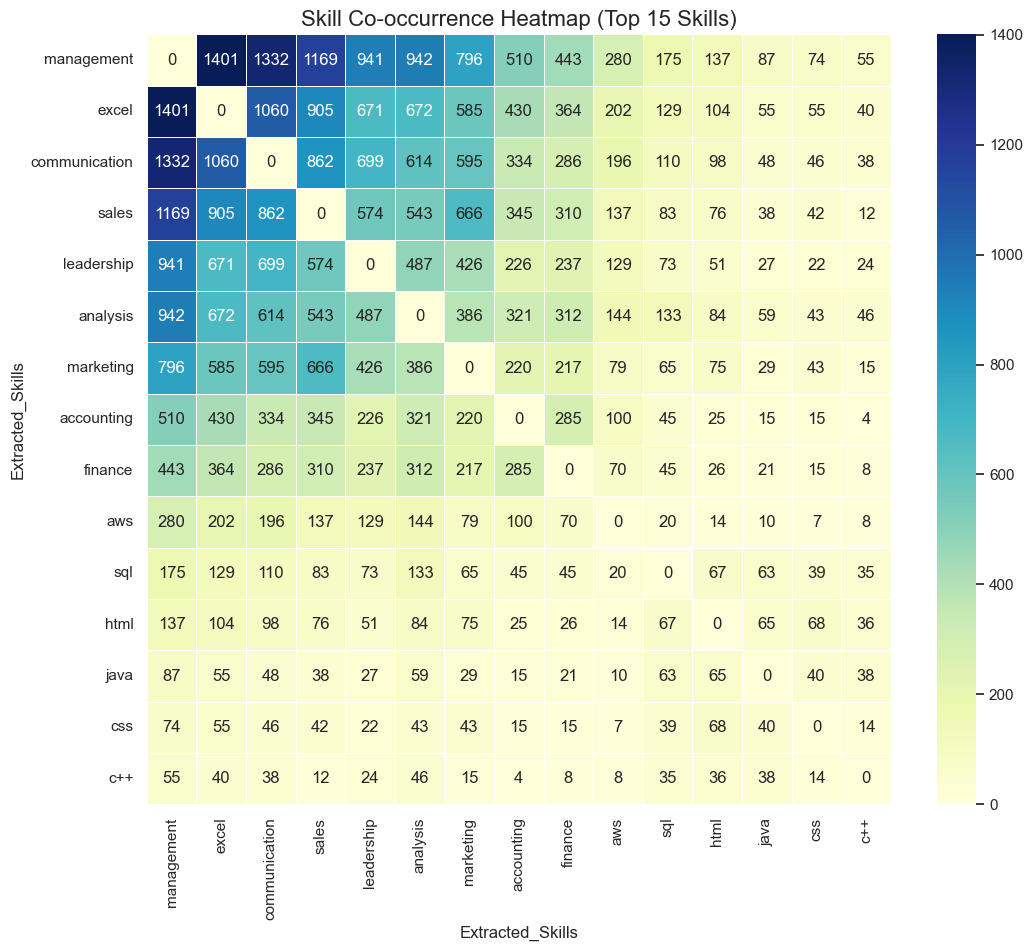

In [10]:
# Common Skills list
common_skills = {
    "python", "java", "c++", "sql", "html", "css", "javascript", "react", 
    "node", "aws", "azure", "docker", "kubernetes", "excel", "power bi", 
    "tableau", "machine learning", "tensorflow", "pytorch", "pandas", 
    "analysis", "management", "communication", "leadership", "sales", 
    "marketing", "finance", "accounting"
}

def extract_skills(text):
    text = str(text).lower()
    return [skill for skill in common_skills if skill in text]

df['Extracted_Skills'] = df['Resume_str'].apply(extract_skills)

# Count Co-occurrences
co_occurrence = Counter()
for skills in df['Extracted_Skills']:
    if len(skills) > 1:
        for pair in combinations(sorted(skills), 2):
            co_occurrence[pair] += 1

# Convert to Matrix
skills_list = sorted(list(common_skills))
matrix = pd.DataFrame(0, index=skills_list, columns=skills_list)

for (s1, s2), count in co_occurrence.items():
    matrix.loc[s1, s2] = count
    matrix.loc[s2, s1] = count # Symmetric

# Filter for better visualization (Top 15 most frequent skills)
top_skills = df['Extracted_Skills'].explode().value_counts().head(15).index
filtered_matrix = matrix.loc[top_skills, top_skills]

# Plot
plt.figure(figsize=(12, 10))
sns.heatmap(filtered_matrix, annot=True, cmap="YlGnBu", fmt='d', linewidths=.5)
plt.title("Skill Co-occurrence Heatmap (Top 15 Skills)", fontsize=16)
plt.show()